# Longformer
## With text prompt explaining Bechdel test

### Imports and Initialization

In [4]:
import os
import torch
from torch.utils.data import DataLoader, Dataset
from torch.amp import GradScaler, autocast
from transformers import LongformerTokenizer, LongformerForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Environment variable for memory allocation
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Tokenizer and Model Initialization
tokenizer = LongformerTokenizer.from_pretrained("allenai/longformer-base-4096")
model = LongformerForSequenceClassification.from_pretrained("allenai/longformer-base-4096", num_labels=2)
model.gradient_checkpointing_enable()
model.config.attention_window = [256] * len(model.config.attention_window)
model = torch.nn.DataParallel(model).to("cuda")
model_name = 'longformer_prompt'

# Initialize results DataFrame
results_df = pd.DataFrame(columns=[
    "model", "split", "accuracy", "f1_score", "roc_auc", 
    "true_negatives", "true_positives", "false_positives", "false_negatives", "precision", "recall", 
    "true_negative_rate", "false_negative_rate", "false_positive_rate"])


Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Dataset and DataLoader setup

In [5]:
# Dataset with optional text prompt
class ScriptDataset(Dataset):
    def __init__(self, scripts, labels, tokenizer, max_length=3072, use_prompt=True):
        self.scripts = scripts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_prompt = use_prompt
        self.prompt = (
            "Does the following manuscript pass the Bechdel test or not? "
            "A movie passes the Bechdel test if it fulfills three requirements: "
            "1) There are at least two named female characters, 2) They have a conversation, "
            "3) About something other than a man. Manuscript: "
        )

    def __len__(self):
        return len(self.scripts)

    def __getitem__(self, idx):
        text = self.prompt + self.scripts[idx] if self.use_prompt else self.scripts[idx]
        label = self.labels[idx]
        inputs = self.tokenizer(
            text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        return {
            "input_ids": inputs["input_ids"].squeeze(0),
            "attention_mask": inputs["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)
        }

# DataLoader Preparation
def prepare_dataloader(data, tokenizer, max_length, batch_size, use_prompt=True):
    dataset = ScriptDataset(
        scripts=data["script"].tolist(),
        labels=data["passed_bechdel"].tolist(),
        tokenizer=tokenizer,
        max_length=max_length,
        use_prompt=use_prompt
    )
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Load datasets
train_data = pd.read_csv("../2_preprocessing/train_case_sensitive.csv")
val_data = pd.read_csv("../2_preprocessing/validation_case_sensitive.csv")
test_data = pd.read_csv("../2_preprocessing/test_case_sensitive.csv")

# Create DataLoaders
train_loader = prepare_dataloader(train_data, tokenizer, max_length=3072, batch_size=1, use_prompt=True)
val_loader = prepare_dataloader(val_data, tokenizer, max_length=3072, batch_size=1, use_prompt=True)
test_loader = prepare_dataloader(test_data, tokenizer, max_length=3072, batch_size=1, use_prompt=True)


### Training Loop

In [6]:
# Optimizer, Loss, and Scaler
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=0.001)
criterion = torch.nn.CrossEntropyLoss()
scaler = GradScaler()
gradient_accumulation_steps = 4

# Training Loop
def train(model, dataloader):
    model.train()
    total_loss, total_correct = 0, 0
    optimizer.zero_grad()

    for step, batch in enumerate(dataloader):
        input_ids = batch["input_ids"].to("cuda")
        attention_mask = batch["attention_mask"].to("cuda")
        labels = batch["label"].to("cuda")

        with autocast("cuda"):
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)
            loss = loss / gradient_accumulation_steps

        scaler.scale(loss).backward()

        if (step + 1) % gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        total_loss += loss.item() * gradient_accumulation_steps
        total_correct += (outputs.logits.argmax(1) == labels).sum().item()

        if step % 50 == 0:
            torch.cuda.empty_cache()

    return total_loss / len(dataloader), total_correct / len(dataloader.dataset)

# Training
epochs = 3
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    train_loss, train_accuracy = train(model, train_loader)
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")


Epoch 1/3
Train Loss: 0.6479, Train Accuracy: 0.6213
Epoch 2/3
Train Loss: 0.5649, Train Accuracy: 0.7102
Epoch 3/3
Train Loss: 0.4942, Train Accuracy: 0.7722


### Evaluation Loop


Validation Metrics:
Accuracy: 0.7458
F1 Score: 0.6939
ROC-AUC: 0.8490
Confusion Matrix:
[[81  7]
 [38 51]]


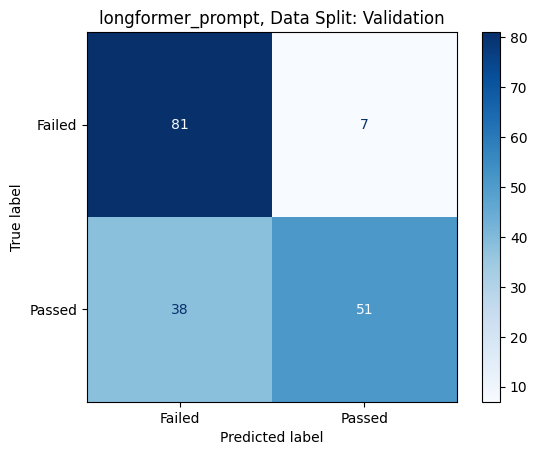

Validation Loss: 0.5480, Validation Accuracy: 0.7458, Validation F1: 0.6939, Validation ROC-AUC: 0.8490

Test Metrics:
Accuracy: 0.6966
F1 Score: 0.6301
ROC-AUC: 0.7257
Confusion Matrix:
[[78 10]
 [44 46]]


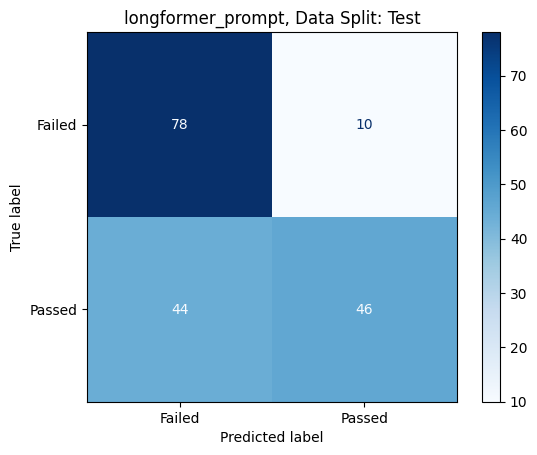

Test Loss: 0.6771, Test Accuracy: 0.6966, Test F1: 0.6301, Test ROC-AUC: 0.7257


In [7]:
# Ensure output directory exists
os.makedirs('./output/figures', exist_ok=True)

# Evaluation Loop
def evaluate(model, dataloader, dataset_name):
    global results_df
    model.eval()
    total_loss, total_correct = 0, 0
    all_preds, all_labels, all_probs = [], [], []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to("cuda")
            attention_mask = batch["attention_mask"].to("cuda")
            labels = batch["label"].to("cuda")

            with autocast("cuda"):
                outputs = model(input_ids, attention_mask=attention_mask)
                loss = criterion(outputs.logits, labels)

            total_loss += loss.item()
            total_correct += (outputs.logits.argmax(1) == labels).sum().item()
            all_preds.extend(outputs.logits.argmax(1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(torch.softmax(outputs.logits, dim=1)[:, 1].cpu().numpy())

    accuracy = total_correct / len(dataloader.dataset)
    f1 = f1_score(all_labels, all_preds)
    roc_auc = roc_auc_score(all_labels, all_probs)
    conf_matrix = confusion_matrix(all_labels, all_preds)

    print(f"\n{dataset_name.capitalize()} Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"Confusion Matrix:\n{conf_matrix}")

    # Save metrics
    tn, fp, fn, tp = conf_matrix.ravel()
    results_df.loc[len(results_df)] = {
        "model": model_name, 
        "split": dataset_name, 
        "accuracy": accuracy,
        "f1_score": f1, 
        "roc_auc": roc_auc,
        "true_negatives": tn, 
        "true_positives": tp,
        "false_positives": fp,
        "false_negatives": fn, 
        "precision": tp / (tp + fp), 
        "recall": tp / (tp + fn), 
        "true_negative_rate": tn / (tn + fp), 
        "false_negative_rate": fn / (fn + tp), 
        "false_positive_rate": fp / (fp + tn)
    }

    # Save confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Failed", "Passed"])
    disp.plot(cmap=plt.cm.Blues)
    disp.ax_.set_title(f"{model_name}, Data Split: {dataset_name.capitalize()}")
    plt.savefig(f'./output/figures/{model_name}_{dataset_name}_confusion_matrix.jpeg')
    plt.show()

    return total_loss / len(dataloader), accuracy, f1, roc_auc

# Evaluate on Validation Data
val_loss, val_accuracy, val_f1, val_roc_auc = evaluate(model, val_loader, "validation")
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Validation F1: {val_f1:.4f}, Validation ROC-AUC: {val_roc_auc:.4f}")

# Evaluate on Test Data
test_loss, test_accuracy, test_f1, test_roc_auc = evaluate(model, test_loader, "test")
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test F1: {test_f1:.4f}, Test ROC-AUC: {test_roc_auc:.4f}")

# Save Results to CSV
results_df.to_csv("./output/longformer_prompt_evaluation.csv", index=False)


## -------------------------------------

# Longformer
## Without text prompt

### Imports and Initialization

In [1]:
import os
import torch
from torch.utils.data import DataLoader, Dataset
from torch.amp import GradScaler, autocast
from transformers import LongformerTokenizer, LongformerForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Environment variable for memory allocation
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Tokenizer and Model Initialization
tokenizer = LongformerTokenizer.from_pretrained("allenai/longformer-base-4096")
model = LongformerForSequenceClassification.from_pretrained("allenai/longformer-base-4096", num_labels=2)
model.gradient_checkpointing_enable()
model.config.attention_window = [256] * len(model.config.attention_window)
model = torch.nn.DataParallel(model).to("cuda")
model_name = 'longformer_noprompt'

# Initialize results DataFrame
results2_df = pd.DataFrame(columns=[
    "model", "split", "accuracy", "f1_score", "roc_auc", 
    "true_negatives", "true_positives", "false_positives", "false_negatives", "precision", "recall", 
    "true_negative_rate", "false_negative_rate", "false_positive_rate"])


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/597M [00:00<?, ?B/s]

Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Dataset and DataLoader setup

In [2]:
# Dataset with optional text prompt
class ScriptDataset(Dataset):
    def __init__(self, scripts, labels, tokenizer, max_length=3072, use_prompt=False):
        self.scripts = scripts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_prompt = use_prompt
        self.prompt = (
            "Does the following manuscript pass the Bechdel test or not? "
            "A movie passes the Bechdel test if it fulfills three requirements: "
            "1) There are at least two named female characters, 2) They have a conversation, "
            "3) About something other than a man. Manuscript: "
        )

    def __len__(self):
        return len(self.scripts)

    def __getitem__(self, idx):
        text = self.prompt + self.scripts[idx] if self.use_prompt else self.scripts[idx]
        label = self.labels[idx]
        inputs = self.tokenizer(
            text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        return {
            "input_ids": inputs["input_ids"].squeeze(0),
            "attention_mask": inputs["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)
        }

# DataLoader Preparation
def prepare_dataloader(data, tokenizer, max_length, batch_size, use_prompt=False):
    dataset = ScriptDataset(
        scripts=data["script"].tolist(),
        labels=data["passed_bechdel"].tolist(),
        tokenizer=tokenizer,
        max_length=max_length,
        use_prompt=use_prompt
    )
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Load datasets
train_data = pd.read_csv("../2_preprocessing/train_case_sensitive.csv")
val_data = pd.read_csv("../2_preprocessing/validation_case_sensitive.csv")
test_data = pd.read_csv("../2_preprocessing/test_case_sensitive.csv")

# Create DataLoaders
train_loader = prepare_dataloader(train_data, tokenizer, max_length=3072, batch_size=1, use_prompt=False)
val_loader = prepare_dataloader(val_data, tokenizer, max_length=3072, batch_size=1, use_prompt=False)
test_loader = prepare_dataloader(test_data, tokenizer, max_length=3072, batch_size=1, use_prompt=False)

### Training Loop

In [3]:
# Optimizer, Loss, and Scaler
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=0.001)
criterion = torch.nn.CrossEntropyLoss()
scaler = GradScaler()
gradient_accumulation_steps = 4

# Training Loop
def train(model, dataloader):
    model.train()
    total_loss, total_correct = 0, 0
    optimizer.zero_grad()

    for step, batch in enumerate(dataloader):
        input_ids = batch["input_ids"].to("cuda")
        attention_mask = batch["attention_mask"].to("cuda")
        labels = batch["label"].to("cuda")

        with autocast("cuda"):
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)
            loss = loss / gradient_accumulation_steps

        scaler.scale(loss).backward()

        if (step + 1) % gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        total_loss += loss.item() * gradient_accumulation_steps
        total_correct += (outputs.logits.argmax(1) == labels).sum().item()

        if step % 50 == 0:
            torch.cuda.empty_cache()

    return total_loss / len(dataloader), total_correct / len(dataloader.dataset)

# Training
epochs = 3
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    train_loss, train_accuracy = train(model, train_loader)
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")


Epoch 1/3


Initializing global attention on CLS token...


Train Loss: 0.6563, Train Accuracy: 0.5973
Epoch 2/3
Train Loss: 0.5723, Train Accuracy: 0.7059
Epoch 3/3
Train Loss: 0.5204, Train Accuracy: 0.7348


### Evaluation Loop


Validation Metrics:
Accuracy: 0.7740
F1 Score: 0.7468
ROC-AUC: 0.8531
Confusion Matrix:
[[78 10]
 [30 59]]


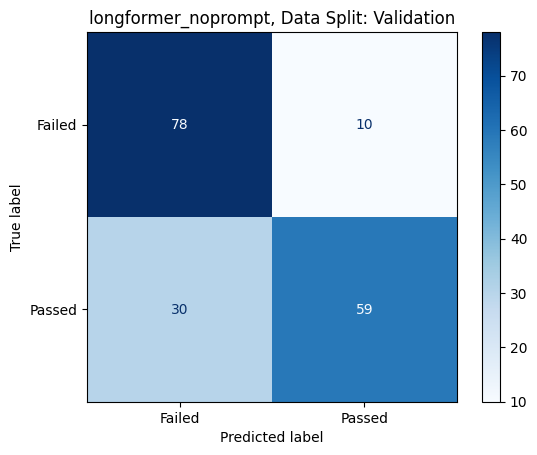

Validation Loss: 0.5064, Validation Accuracy: 0.7740, Validation F1: 0.7468, Validation ROC-AUC: 0.8531

Test Metrics:
Accuracy: 0.6966
F1 Score: 0.6447
ROC-AUC: 0.7160
Confusion Matrix:
[[75 13]
 [41 49]]


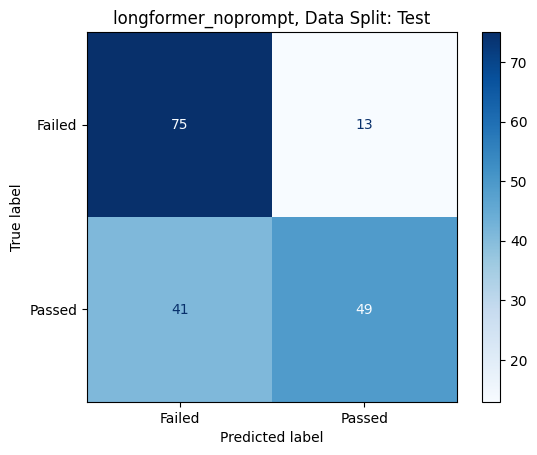

Test Loss: 0.6190, Test Accuracy: 0.6966, Test F1: 0.6447, Test ROC-AUC: 0.7160


In [4]:
# Ensure output directory exists
os.makedirs('./output/figures', exist_ok=True)

# Evaluation Loop
def evaluate(model, dataloader, dataset_name):
    global results2_df
    model.eval()
    total_loss, total_correct = 0, 0
    all_preds, all_labels, all_probs = [], [], []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to("cuda")
            attention_mask = batch["attention_mask"].to("cuda")
            labels = batch["label"].to("cuda")

            with autocast("cuda"):
                outputs = model(input_ids, attention_mask=attention_mask)
                loss = criterion(outputs.logits, labels)

            total_loss += loss.item()
            total_correct += (outputs.logits.argmax(1) == labels).sum().item()
            all_preds.extend(outputs.logits.argmax(1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(torch.softmax(outputs.logits, dim=1)[:, 1].cpu().numpy())

    accuracy = total_correct / len(dataloader.dataset)
    f1 = f1_score(all_labels, all_preds)
    roc_auc = roc_auc_score(all_labels, all_probs)
    conf_matrix = confusion_matrix(all_labels, all_preds)

    print(f"\n{dataset_name.capitalize()} Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"Confusion Matrix:\n{conf_matrix}")

    # Save metrics
    tn, fp, fn, tp = conf_matrix.ravel()
    results2_df.loc[len(results2_df)] = {
        "model": model_name, 
        "split": dataset_name, 
        "accuracy": accuracy,
        "f1_score": f1, 
        "roc_auc": roc_auc,
        "true_negatives": tn, 
        "true_positives": tp,
        "false_positives": fp,
        "false_negatives": fn, 
        "precision": tp / (tp + fp), 
        "recall": tp / (tp + fn), 
        "true_negative_rate": tn / (tn + fp), 
        "false_negative_rate": fn / (fn + tp), 
        "false_positive_rate": fp / (fp + tn)
    }

    # Save confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Failed", "Passed"])
    disp.plot(cmap=plt.cm.Blues)
    disp.ax_.set_title(f"{model_name}, Data Split: {dataset_name.capitalize()}")
    plt.savefig(f'./output/figures/{model_name}_{dataset_name}_confusion_matrix.jpeg')
    plt.show()

    return total_loss / len(dataloader), accuracy, f1, roc_auc

# Evaluate on Validation Data
val_loss, val_accuracy, val_f1, val_roc_auc = evaluate(model, val_loader, "validation")
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Validation F1: {val_f1:.4f}, Validation ROC-AUC: {val_roc_auc:.4f}")

# Evaluate on Test Data
test_loss, test_accuracy, test_f1, test_roc_auc = evaluate(model, test_loader, "test")
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test F1: {test_f1:.4f}, Test ROC-AUC: {test_roc_auc:.4f}")

# Save Results to CSV
results2_df.to_csv("./output/longformer_noprompt_evaluation.csv", index=False)
